In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# cd gdrive/MyDrive/

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!rm -rf face-landmark-detection
!git clone --branch part2 https://github.com/mariaafara/face-landmark-detection.git

Cloning into 'face-landmark-detection'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 304 (delta 115), reused 248 (delta 61), pack-reused 0
Receiving objects: 100% (304/304), 17.12 MiB | 36.76 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [6]:
import os
os.environ['KAGGLE_USERNAME'] = "mariaafara" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file
!rm -rf Facial-Landmarks
# Crearting a Client to host the Kaggle API
!pip install -q kaggle
!kaggle datasets download mariaafara/Facial-Landmarks
!unzip Facial-Landmarks.zip 

 94% 210M/224M [00:02<00:00, 76.3MB/s]
100% 224M/224M [00:02<00:00, 87.9MB/s]
Archive:  Facial-Landmarks.zip
  inflating: dic_missing_data.pkl    
  inflating: dic_train_data.pkl      
  inflating: main_data3.pkl          


In [7]:
ls gdrive/MyDrive/

'Colab Notebooks'/                   'memoNotes(GoogleDocs)_from_old_phone'/
 Crous/                               nmt/
 cvs/                                 NMT.gslides
 docs/                                phd.m4a
 face-landmark-detection/             saved/
'How to get started with Drive.pdf'  'Scans&Docs'/
 main_data3.pkl                       sheets/
 Master1/                             University/


In [8]:
import sys
sys.path.insert(0, "face-landmark-detection/")

In [9]:
from src.utils import *
main_df = load_from_pickle("main_data3.pkl") #the data saved in the label_missing_values.ipynb

os.environ["EPOCHS"] = "100"
os.environ["RGB_CHANNELS"] = "false"
os.environ["PATIENCE_EARLY_STOPPING"] = "8"
path = F"/content/gdrive/My Drive/saved/"
os.environ["TRAIN_SCALER_PATH"] = "{}/scaler.pkl".format(path)
os.environ["WEIGHT_PATH"] = "weights/weight.ckpt"
os.environ["FEATURES_DIMENSIONS"] = "30"
os.environ["MODEL_PATH"] = "{}final_model/model".format(path)

In [10]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from src.config import prediction_model_config as config
from src.model.simple_model import MySimpleModel2
from src.train import fit_model, compile_model
from src.data_preparation import DataGenerator
from IPython.display import clear_output
pd.options.mode.chained_assignment = None  # default='warn'

In [12]:
main_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,nose_tip_x,nose_tip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,44.420571,57.066803,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,48.206298,55.660936,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,47.557263,53.538947,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,51.885078,54.166539,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,43.299534,64.889521,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."


In [14]:
df_train, df_test_val = split_data(main_df, test_size=0.3)
df_val, df_test = split_data(df_test_val, test_size=0.1)
print(main_df.shape, df_train.shape, df_val.shape, df_test.shape)

# fit the MinMaxScaler using the training data and then apply the scaler on the testing data before the prediction.
scaler = create_scaler(df_train.iloc[:,:-1])
save_to_pickle(scaler, config.TRAIN_SCALER_PATH)

train_generator = DataGenerator(df_train, 
                                batch_size=config.BATCH_SIZE,
                                augment= config.AUGMENT_TRAIN,
                                rgb_channels= config.RGB_CHANNELS,
                                normalize_image=config.NORMALIZE_IMAGE,
                                normalize_coordinates=config.NORMALIZE_COORDINATES, 
                                scaler=scaler)

val_generator =  DataGenerator(df_test,
                               batch_size=config.BATCH_SIZE,
                               augment=config.AUGMENT_TRAIN,
                               shuffle=False, 
                               rgb_channels=config.RGB_CHANNELS, 
                               normalize_image=config.NORMALIZE_IMAGE,
                               normalize_coordinates=config.NORMALIZE_COORDINATES,
                               scaler=train_generator.scaler)

test_generator =  DataGenerator(df_test,
                               batch_size=config.BATCH_SIZE,
                               augment=config.AUGMENT_VAL,
                               shuffle=False, 
                               rgb_channels=config.RGB_CHANNELS, 
                               normalize_image=config.NORMALIZE_IMAGE,
                               normalize_coordinates=config.NORMALIZE_COORDINATES,
                               scaler=train_generator.scaler)

(7049, 31) (4934, 31) (1903, 31) (212, 31)


In [15]:
import tensorflow

In [16]:
my_model = MySimpleModel2(config.IMAGE_SHAPE, config.FEATURES_DIMENSIONS)
compile_model(my_model, optimizer=tensorflow.keras.optimizers.Adam(0.001), loss='mean_squared_error', metrics=['mae'])
my_model, history = fit_model(my_model, config.EPOCHS, train_generator, val_generator, config.WEIGHT_PATH)

Epoch 1/100
154/154 [==============================] - 19s 74ms/step - loss: 0.0630 - mae: 0.1835 - val_loss: 0.0092 - val_mae: 0.0711

Epoch 00001: val_loss improved from inf to 0.00918, saving model to weights/weight.ckpt
Epoch 2/100
154/154 [==============================] - 11s 72ms/step - loss: 0.0119 - mae: 0.0830 - val_loss: 0.0058 - val_mae: 0.0558

Epoch 00002: val_loss improved from 0.00918 to 0.00578, saving model to weights/weight.ckpt
Epoch 3/100
154/154 [==============================] - 11s 73ms/step - loss: 0.0091 - mae: 0.0722 - val_loss: 0.0059 - val_mae: 0.0566

Epoch 00003: val_loss did not improve from 0.00578
Epoch 4/100
154/154 [==============================] - 11s 72ms/step - loss: 0.0078 - mae: 0.0669 - val_loss: 0.0050 - val_mae: 0.0509

Epoch 00004: val_loss improved from 0.00578 to 0.00497, saving model to weights/weight.ckpt
Epoch 5/100
154/154 [==============================] - 11s 72ms/step - loss: 0.0073 - mae: 0.0639 - val_loss: 0.0048 - val_mae: 0.052

In [17]:
# Recreat the same structure of the model and load its saved weights then build it by predicting a random input then save the model
from src.train import compile_model
from tensorflow.keras.models import load_model

model = MySimpleModel2(config.IMAGE_SHAPE, config.FEATURES_DIMENSIONS)

model.load_weights(config.WEIGHT_PATH)
model.predict(tf.expand_dims(tf.random.uniform(model.image_shape), axis=0))
model.save(config.MODEL_PATH) 

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/saved/final_model/model/assets


In [18]:
# load the model to check it
m = load_model(config.MODEL_PATH, compile=False)
m.predict(tf.expand_dims(tf.random.uniform(model.image_shape), axis=0))

array([[0.6199908 , 0.41755223, 0.3154844 , 0.42732635, 0.6525477 ,
        0.18038349, 0.70050967, 0.19438615, 0.3907263 , 0.20998356,
        0.2899625 , 0.24720079, 0.60748494, 0.25113338, 0.7727035 ,
        0.27399525, 0.41494486, 0.24741504, 0.1810227 , 0.28735104,
        0.67078084, 0.5361627 , 0.41446352, 0.61795557, 0.48987448,
        0.5829248 , 0.4860183 , 0.7405319 , 0.446541  , 0.5964858 ]],
      dtype=float32)

In [19]:
compile_model(m)
m.evaluate(test_generator)

6/6 [==============================] - 0s 6ms/step - loss: 0.3505 - mae: 0.0492


[0.34972691535949707, 0.04905979335308075]

#### **Evaluate the model**

In [20]:
my_model.evaluate(test_generator)

6/6 [==============================] - 0s 13ms/step - loss: 0.0016 - mae: 0.0285


[0.0015988615341484547, 0.028510907664895058]

Text(0.5, 1.0, 'Training and validation loss')

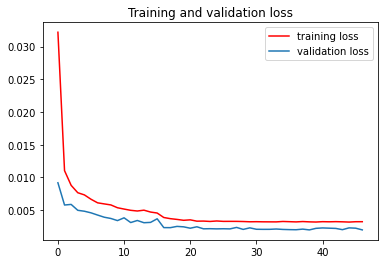

In [21]:
# Retrieve a list of list results on training and test data sets for each training epoch
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(loss))
# Plot training and validation loss per epoch
plt.plot(epochs,loss, color='red' , label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.title ('Training and validation loss')

In [22]:
test_generator_with_augmentation =  DataGenerator(df_test,
                               batch_size=config.BATCH_SIZE,
                               augment=config.AUGMENT_TRAIN,
                               shuffle=False, 
                               rgb_channels=config.RGB_CHANNELS, 
                               normalize_image=config.NORMALIZE_IMAGE,
                               normalize_coordinates=config.NORMALIZE_COORDINATES,
                               scaler=train_generator.scaler)

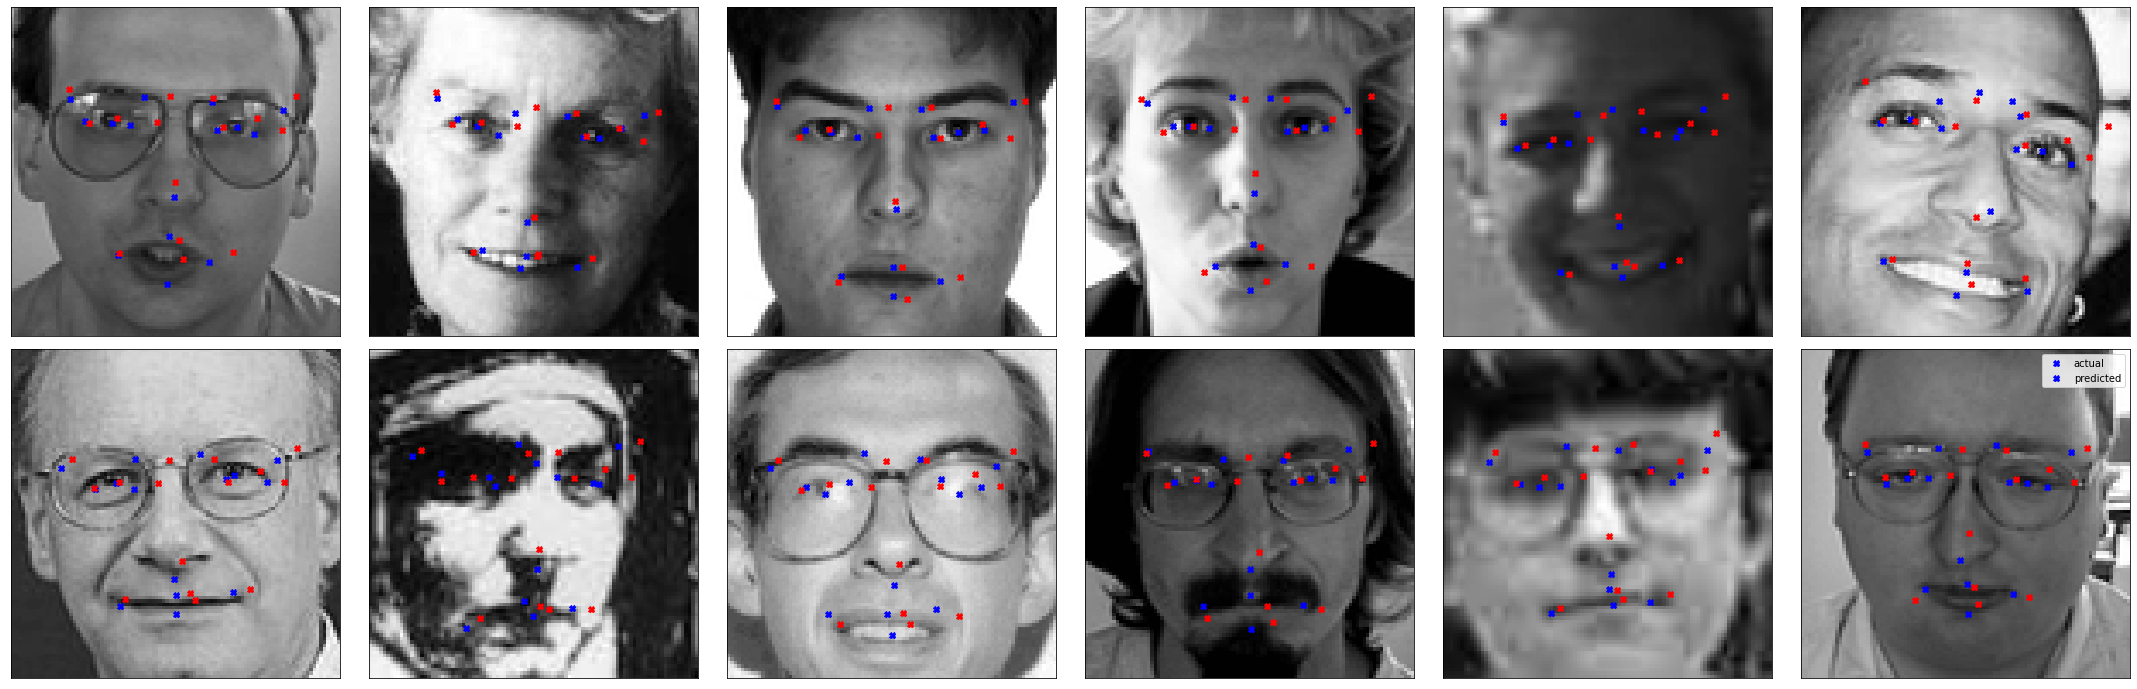

In [26]:
batch = test_generator.__getitem__(4)
visualize_random_predicted_images(m, batch, scaler)

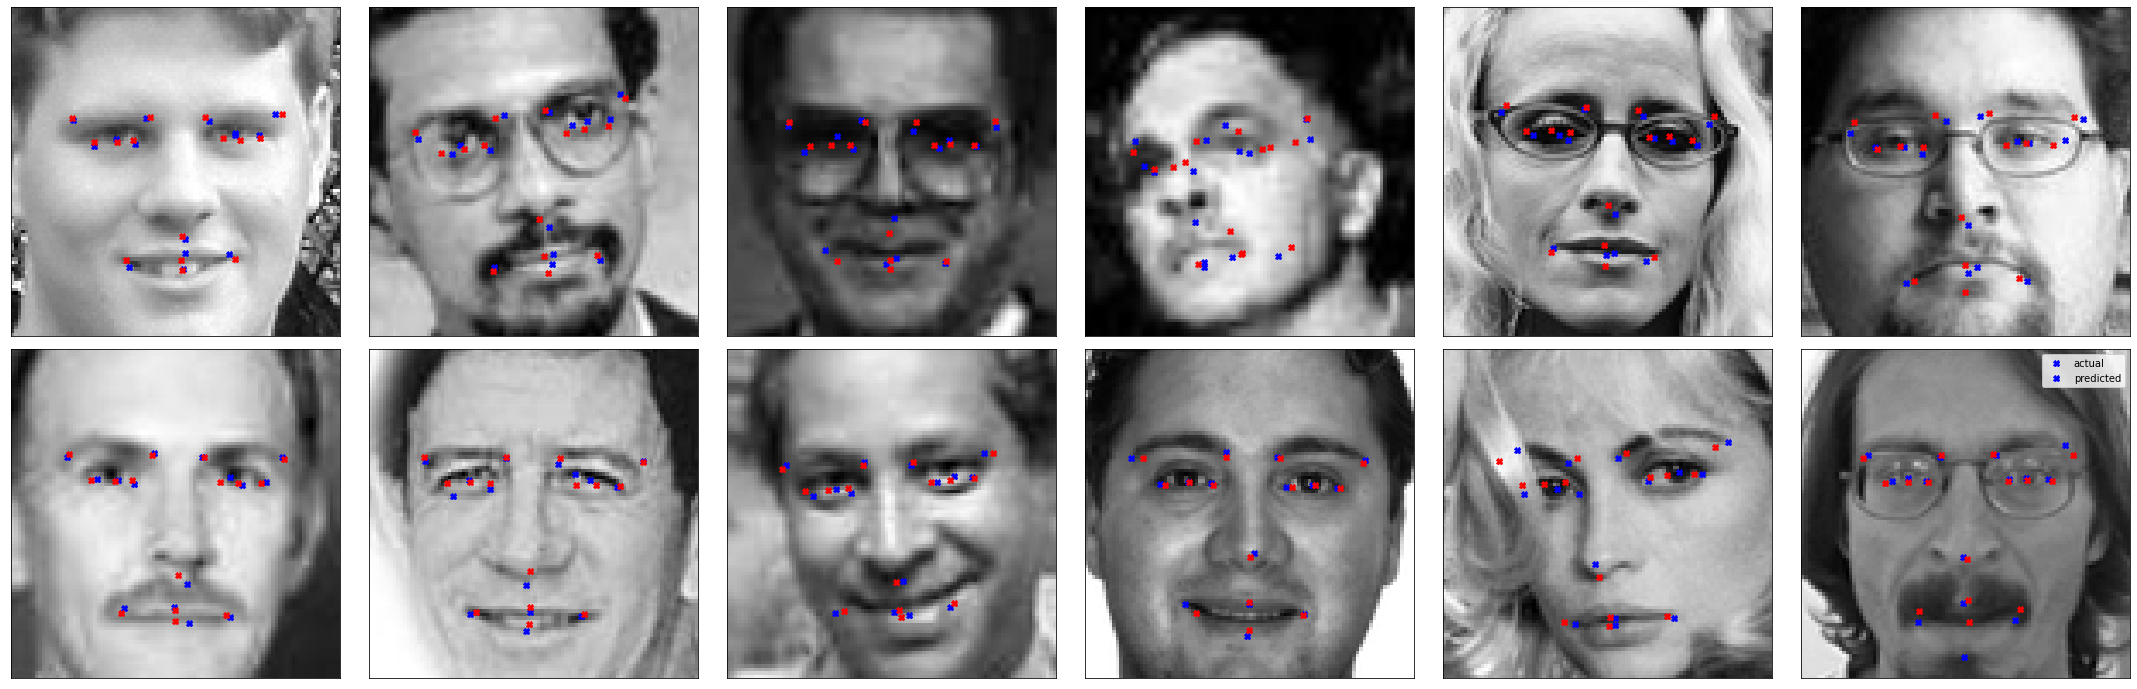

In [28]:
batch = test_generator.__getitem__(2)
visualize_random_predicted_images(my_model, batch[:12], scaler)